# Predictive Maintenance Modeling on Amazon SageMaker - Advanced

Predictive Maintenance using ML enables you to perform automated data processing on any data. 
In this notebook, we are going leverage **Apache Airflow** with **Amazaon SageMaker** to build a model that detects potential equipment failures and provides recommended actions to take. The diagram below is the genearl architecture of SageMaker and Airflow.

## AWS Architecture

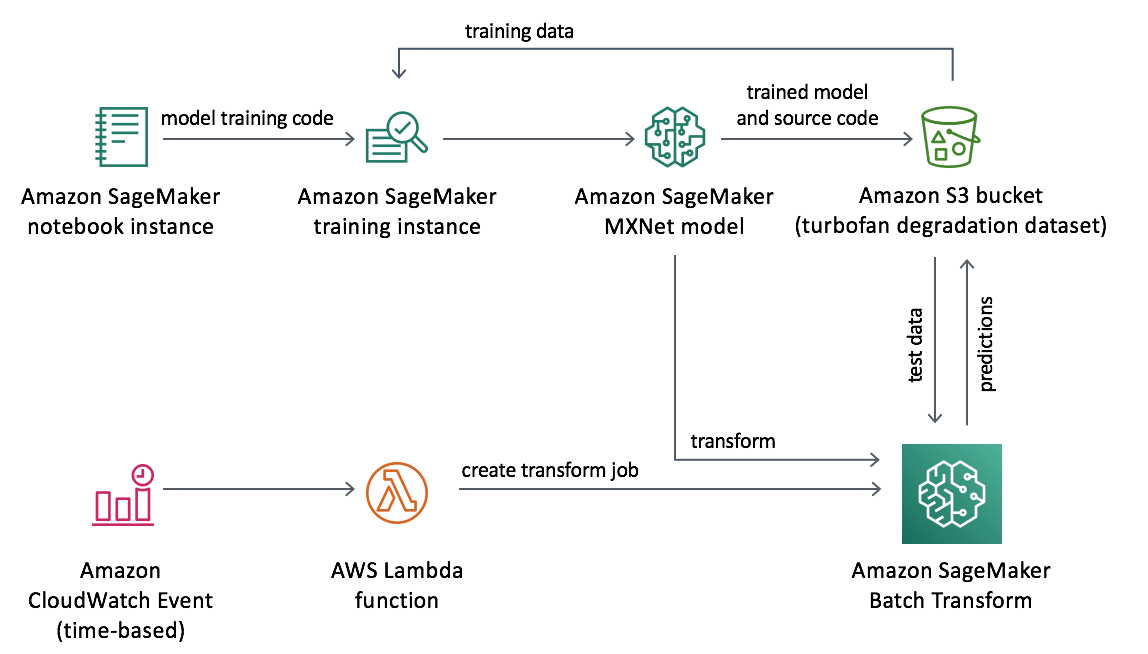

In [1]:
from IPython.display import Image
file_name1 = './img/predictive-maintenance.png'
Image(file_name1)

Predictive Maintenance Using Machine Learning architecture
This solution includes an AWS CloudFormation template that deploys an example dataset of a turbofan degradation simulation contained in an Amazon Simple Storage Service (Amazon S3) bucket and an Amazon SageMaker endpoint with an ML model that will be trained on the dataset to predict remaining useful life (RUL).

The solution uses a SageMaker notebook instance to orchestrate the model, and a SageMaker training instance to perform the training. The training code and trained model are stored in the solution's Amazon S3 bucket.

The solution also deploys an Amazon CloudWatch Events rule that is configured to run once per day. The rule is configured to trigger an AWS Lambda function that creates an Amazon SageMaker batch transform job that uses the trained model to predict RUL from the example dataset.

By default, the solution is configured to predict RUL from the example dataset.

For more information on how to deploy your solution, see the [deployment guide](https://docs.aws.amazon.com/solutions/latest/predictive-maintenance-using-machine-learning/welcome.html).

#### If you want deploy solutions similar to this, you must modify the solution and convert your dataset to an Apache MXNet Gluon dataset. 
#### For more information on how to setup a training script for SageMaker using the MXNet estimator, Please go to this [Link](https://sagemaker.readthedocs.io/en/stable/using_mxnet.html#preparing-the-mxnet-training-script)

In this dataset, Four different sets were simulated under different combinations of operational conditions and fault modes. Several sensor channels were recorded for the dataset to characterize fault evolution.

In [19]:
import numpy as np                                # For matrix operations and numerical processing
import pandas as pd                               # For munging tabular data
import matplotlib.pyplot as plt                   # For charts and visualizations
%matplotlib inline
from IPython.display import Image                 # For displaying images in the notebook
from IPython.display import display               # For displaying outputs in the notebook
from time import gmtime, strftime                 # For labeling SageMaker models, endpoints, etc.
import sys                                        # For writing outputs to notebook
import math                                       # For ceiling function
import json                                       # For parsing hosting outputs
import os                                         # For manipulating filepath names
import jsonlines
import boto3 
import csv
import io
import re
import s3fs
import copy
import random
import time
from time import strftime, gmtime
from scipy.sparse import lil_matrix

# plot aesthetics
import seaborn as sns
sns.set(color_codes=True)
sns.set_context('paper')
five_thirty_eight = ["#30a2da", "#fc4f30", "#e5ae38", "#6d904f", "#8b8b8b",]
sns.set_palette(five_thirty_eight)

%matplotlib inline

from urllib.request import urlretrieve
import zipfile
from dateutil.parser import parse
from random import shuffle
import random
import datetime
import urllib

import sagemaker                                 
from sagemaker.predictor import csv_serializer 
from sagemaker.predictor import json_deserializer
import sagemaker.amazon.common as smac
from sagemaker import get_execution_role
from sagemaker.tuner import HyperparameterTuner, ContinuousParameter
from sagemaker.analytics import HyperparameterTuningJobAnalytics, TrainingJobAnalytics

In [20]:
sess   = sagemaker.Session()
bucket = sess.default_bucket()                     
prefix = 'pred-maintenance'
region = boto3.Session().region_name
role = 'arn:aws:iam::570447867175:role/SageMakerNotebookRole' # pass your IAM role name

print('Sagemaker session :', sess)
print('S3 bucket :', bucket)
print('Prefix :', prefix)
print('Region selected :', region)
print('IAM role :', role)

Sagemaker session : <sagemaker.session.Session object at 0x000001C416EBB7C8>
S3 bucket : sagemaker-us-west-2-570447867175
Prefix : pred-maintenance
Region selected : us-west-2
IAM role : arn:aws:iam::570447867175:role/SageMakerNotebookRole


### 1. Load Data

In [21]:
data_folder = 'data'
if not os.path.exists(data_folder):
    os.makedirs(data_folder)
urllib.request.urlretrieve('https://ti.arc.nasa.gov/m/project/prognostic-repository/CMAPSSData.zip', os.path.join(data_folder, 'CMAPSSData.zip'))

with zipfile.ZipFile(os.path.join(data_folder, 'CMAPSSData.zip'), "r") as zip_ref:
    zip_ref.extractall(data_folder)
    
columns = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3','s4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14','s15', 's16', 's17', 's18', 's19', 's20', 's21']

### 2. Data Pre-processing

##### (1) Training Data

There are 4 different dataset and we would need to train our models on each individually

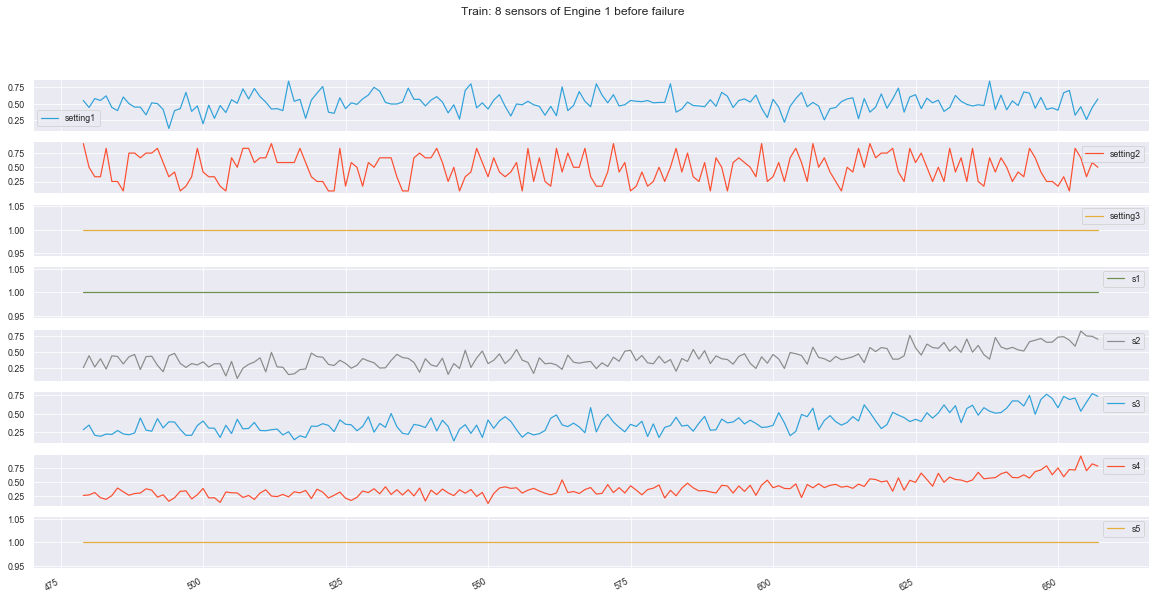

In [22]:
# normalize sensor readings
train_df = []
eps = 0.000001 # for floating point issues during normalization 
for i in range(1,5):
    df = pd.read_csv('data/train_FD{:03d}.txt'.format(i), delimiter=' ', header=None)
    df.drop(df.columns[[26, 27]], axis=1, inplace=True)
    df.columns = columns
    df[columns[2:]]=(df[columns[2:]]-df[columns[2:]].min()+eps)/(df[columns[2:]].max()-df[columns[2:]].min()+eps)
    train_df.append(df)

# compute RUL (remaining useful life)
for i, df in enumerate(train_df):
    rul = pd.DataFrame(df.groupby('id')['cycle'].max()).reset_index()
    rul.columns = ['id', 'max']
    df = df.merge(rul, on=['id'], how='left')
    df['RUL'] = df['max'] - df['cycle']
    df.drop('max', axis=1, inplace=True)
    train_df[i]=df

train_df[0].head()
o = train_df[0][columns[2:10]][train_df[0]['id'] == 3].plot(subplots=True, sharex=True, figsize=(20,10), title="Train: 8 sensors of Engine 1 before failure")

##### (2) Test Data

In [23]:
test_df = []
for i in range(1,5):
    # Load time series
    df = pd.read_csv('data/test_FD{:03d}.txt'.format(i), delimiter=' ', header=None)
    df.drop(df.columns[[26, 27]], axis=1, inplace=True)
    
    # Load the RUL values
    df_rul = pd.read_csv('data/RUL_FD{:03d}.txt'.format(i), delimiter=' ', header=None)    
    df_rul.drop(df_rul.columns[1], axis=1, inplace=True)
    df_rul.index += 1
    
    # Merge RUL and timeseries and compute RUL per timestamp
    df = df.merge(df_rul, left_on=df.columns[0], right_index=True, how='left')
    df.columns = columns + ['RUL_end']
    rul = pd.DataFrame(df.groupby('id')['cycle'].max()).reset_index()
    rul.columns = ['id', 'max']
    df = df.merge(rul, on=['id'], how='left') # We get the number of cycles per series
    df['RUL'] = df['max'] + df['RUL_end'] - df['cycle'] # The RUL is the number of cycles per series + RUL - how many cycles have already ran
    df.drop(['max','RUL_end'], axis=1, inplace=True)
    
    # Normalize
    df[columns[2:]]=(df[columns[2:]]-df[columns[2:]].min()+eps)/(df[columns[2:]].max()-df[columns[2:]].min()+eps)
    test_df.append(df)

In [24]:
test_df

[        id  cycle  setting1  setting2  setting3   s1        s2        s3  \
 0        1      1  0.656271  0.692544       1.0  1.0  0.596215  0.421968   
 1        1      2  0.343791  0.231360       1.0  1.0  0.182966  0.504025   
 2        1      3  0.531279  0.538816       1.0  1.0  0.419559  0.464814   
 3        1      4  0.775014  0.461952       1.0  1.0  0.413249  0.391587   
 4        1      5  0.600025  0.461952       1.0  1.0  0.435331  0.471306   
 ...    ...    ...       ...       ...       ...  ...       ...       ...   
 13091  100    194  0.818761  0.461952       1.0  1.0  0.665615  0.789665   
 13092  100    195  0.443785  0.385088       1.0  1.0  0.659306  0.692028   
 13093  100    196  0.475033  0.231360       1.0  1.0  0.728707  0.626071   
 13094  100    197  0.275045  0.538816       1.0  1.0  0.671924  0.673851   
 13095  100    198  0.593775  0.692544       1.0  1.0  0.574133  0.846014   
 
              s4   s5  ...       s13       s14       s15  s16    s17  s18 

### 3. Convert to Protobuf format and Upload to S3

In [25]:
s3_bucket_resource = boto3.resource('s3').Bucket(bucket)

# Upload raw data files to S3
for subdir, dirs, files in os.walk(data_folder):
    for file in files:
        full_path = os.path.join(subdir, file)
        s3_path = os.path.join(prefix, full_path)
        s3_bucket_resource.Object(s3_path).upload_file(full_path)

# Upload processed test data for inference
for i in range(len(test_df)):
    local_test_file = 'data/test-{}.csv'.format(i)
    test_df[i].to_csv(local_test_file)
    s3_test_file = os.path.join(prefix, 'data', 'test-{}.csv'.format(i))
    s3_bucket_resource.Object(s3_test_file).upload_file(local_test_file)

# Upload processed data for training
for i in range(len(train_df)):
    local_train_file = 'data/train-{}.csv'.format(i)
    train_df[i].to_csv(local_train_file)
    s3_train_file = os.path.join(prefix, 'train', 'train-{}.csv'.format(i))
    s3_bucket_resource.Object(s3_train_file).upload_file(local_train_file)

In [26]:
s3_train_data = 's3://{}/{}/{}'.format(bucket, prefix, 'train')
s3_test_data = 's3://{}/{}/{}'.format(bucket, prefix, 'test')

print('uploaded training data location: {}'.format(s3_train_data))
print('uploaded test data location: {}'.format(s3_test_data))

uploaded training data location: s3://sagemaker-us-west-2-570447867175/pred-maintenance/train
uploaded test data location: s3://sagemaker-us-west-2-570447867175/pred-maintenance/test


In [27]:
# output path
output_location = 's3://{}/{}/output'.format(bucket, prefix)
print('Output will be uploaded to: {}'.format(output_location))

Output will be uploaded to: s3://sagemaker-us-west-2-570447867175/pred-maintenance/output


### 4. Model Training with MXNet

Training MXNet models using MXNet Estimators is a two-step process. First, you prepare your training script, then second, you run this on SageMaker via an MXNet Estimator. The training script we have prepared for the model is located in the sagemaker_predictive_maintenance_entry_point folder.

In [28]:
!pygmentize sagemaker_predictive_maintenance_entry_point.py

import os
import json
import time
import argparse
import logging
import random

import mxnet as mx
from mxnet import gluon, autograd, nd
import gluonnlp
from gluonnlp.data.batchify import Pad, Stack, Tuple
import pandas as pd
import numpy as np


def get_logger(name):
    logger = logging.getLogger(name)
    log_format = '%(asctime)s %(levelname)s %(name)s: %(message)s'
    logging.basicConfig(format=log_format, level=logging.INFO)
    return logger


def parse_args():
    parser = argparse.ArgumentParser()

    parser.add_argument('--num-gpus', type=int, default=1)
    parser.add_argument('--training-dir', type=str, default=os.environ['SM_CHANNEL_TRAIN'])
    parser.add_argument('--num-datasets', type=int, default=1)
    parser.add_argument('--batch-size', type=int, default=1)
    parser.add_argument('--epochs', type=int, default=2)
    parser.add_argument('--learning-rate', type=float, default=0.001)
    parser.add_argument('--log-interval', type=int, default=1000)
    parser.add_arg

In [29]:
from sagemaker.mxnet import MXNet

training_job_name = 'pred-maintenance-mxnet'
train_instance_type = 'ml.p2.xlarge'

m = MXNet(entry_point='sagemaker_predictive_maintenance_entry_point.py',
          #source_dir='sagemaker_predictive_maintenance_entry_point',
          py_version='py3',
          role=role, 
          train_instance_count=1, 
          train_instance_type=train_instance_type,
          output_path=output_location,
          hyperparameters={'num-datasets' : len(train_df),
                           'num-gpus': 1,
                           'epochs': 500,
                           'optimizer': 'adam',
                           'batch-size':1,
                           'log-interval': 100},
         input_mode='File',
         train_max_run=3600,
         framework_version='1.6.0')

In [ ]:
# Start training
m.fit({'train': s3_train_data}, job_name=training_job_name)

### 5. Create Transformer Model

We can now call the transformer function to create a SageMaker Model with the trained model. The SageMaker Model will have the same name as the training job that just completed. This will ensure that SageMaker stores a reference to the trained model which can be used for predictions later on.

In [ ]:
batch_output = 's3://{}/{}/{}'.format(bucket, prefix, 'batch-inference')
transformer = m.transformer(instance_count=1, instance_type='ml.t2.medium', output_path=batch_output) # or instance_type='ml.m4.xlarge'

### 6. Transform test data using the transformer model

Using the transformer SageMaker Model, we can run a SageMaker Batch Transform job to get some predictions on test dataset for the model. Here we have a function that takes some test data in S3 and copies it to a new location where it's used as the input to the transform function of the Batch Transformer.

In [ ]:
s3_test_key = "pred-maintenance-artifacts/data/test-0.csv"
s3_transform_input = os.path.join(prefix, "batch-transform-input")

def get_transform_input():
    s3_client = boto3.client('s3')
    s3_response = s3_client.get_object(Bucket=bucket, Key=s3_test_key)
    test_file = s3_response["Body"].read()

    test_df_entry = pd.read_csv(io.BytesIO(test_file))
    test_data = test_df_entry[test_df_entry['id']==0+1][test_df_entry.columns[2:-1]].values
    test_data = test_data[0:test_data.shape[0]-1,:].astype('float32')
    data_payload = {'input':np.expand_dims(test_data, axis=0).tolist()}
    
    job_name = 'predictive-maintenance-batch-transform-job-{}'.format(strftime("%Y-%m-%d-%H-%M-%S", gmtime()))
    s3_batch_transform_input_key = os.path.join(s3_transform_input, job_name)
    
    s3_client.put_object(Body=json.dumps(data_payload),
                         Bucket=bucket, 
                         Key=s3_batch_transform_input_key)
    return job_name, 's3://{}/{}'.format(bucket, s3_batch_transform_input_key)

job_name, input_key = get_transform_input()
transformer.transform(input_key, wait=True)

### 7. Evaluate model prediction on test-set

In [ ]:
def get_transform_output():
    s3_client = boto3.client('s3')
    s3_response = s3_client.get_object(Bucket=bucket, Key=os.path.join(prefix, 
                                                                       'batch-inference', 
                                                                       job_name+'.out'))
    transform_out = np.array(eval(s3_response["Body"].read()))
    return transform_out
    
get_transform_output()

Reference
>https://github.com/awslabs/predictive-maintenance-using-machine-learning
>https://docs.aws.amazon.com/solutions/latest/predictive-maintenance-using-machine-learning/overview.html